In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from sainomore import Elissabeth, data
from sainomore.elissabeth import Weighting
from sainomore.lightning import TokenPredictionModule

In [2]:
x, y = data.long_lookup(1000, 25, 5, False)

In [4]:

class LookUpElissabeth(Elissabeth):
    """Elissabeth, but the output is subtracted by a shifted version of
    the input."""

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        logits = super().forward(x)
        logits = (logits
            - torch.nn.functional.pad(
                self.embedding(x)[:, :-1], (0, 0, 1, 0)
            )
        )
        return logits

In [57]:
alpha = 50
config = {
    "context_length" : "25",
    "input_vocab_size" : "5",
    "d_hidden" : "5",
    "n_layers" : "1",
    "layer_norm" : "False",

    "n_is" : "2",
    "length_is" : "3",
    "d_values" : "5",
    "values_2D" : "False",
    "pe_value" : "False",
    "residual_stream": "False",

    "restrict_query_key" : "False",
    "exponent": "1",
    "d_query_key": "3",

    "bias" : "False",

    "share_queries" : "False",
    "share_keys" : "False",
    "share_values" : "False",

    "alpha_multiplier" : f"{alpha}",
    "sum_normalization" : "False",
}
model = LookUpElissabeth.build(
    config,
    Weighting.COSINE,
    # Weighting.RELATIVE_DISTANCE,
)

In [58]:
state_dict = model.state_dict()

state_dict["embedding.weight"] = torch.eye(5)
state_dict["layers.0.W_V"] = torch.Tensor([
    [
        [[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]],

        [[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]],

        [[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]]
    ],
    [
        [[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]],

        [[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]],

        [[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]]
    ],
]).unsqueeze(-1)

state_dict["layers.0.W_O"] = torch.Tensor([
    [
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
    ],
    [
        [-1, 0, 0, 0, 0],
        [0, -1, 0, 0, 0],
        [0, 0, -1, 0, 0],
        [0, 0, 0, -1, 0],
        [0, 0, 0, 0, -1],
    ],
]).unsqueeze(2)
state_dict["unembedding.weight"] = torch.eye(5)

# state_dict["layers.0.weightings.1.alpha"] = torch.Tensor([[
#     [10_000, 0]
# ]]).unsqueeze(-1).unsqueeze(-1)

d = torch.pi / 2
state_dict["layers.0.weightings.0.W_Q"] = torch.Tensor([
    [
        [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [d, 0, 0], [0, d, 0], [0, 0, d], [d, d, 0]],
    ],
    [
        [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [d, 0, 0], [0, d, 0], [0, 0, d], [d, d, 0]],
    ],
])
state_dict["layers.0.weightings.0.W_K"] = torch.Tensor([
    [
        [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [d, 0, 0], [0, d, 0], [0, 0, d], [d, d, 0]],
    ],
    [
        [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [d, 0, 0], [0, d, 0], [0, 0, d], [d, d, 0]],
    ],
])

model.load_state_dict(state_dict)

<All keys matched successfully>

In [59]:
model.attach_all_hooks()
out = model(x).detach()# - torch.nn.functional.one_hot(x, 5)
model.release_all_hooks()

In [60]:
print(f"Score: {torch.sum(y[:, -1] == out.argmax(2)[:, -1]) / y.shape[0]}")

Score: 0.2980000078678131


In [61]:
V.shape

torch.Size([1000, 25, 2, 2, 5])

In [62]:
q = model.get_hook("layers.0.weightings.0", "Q").fwd.numpy()
k = model.get_hook("layers.0.weightings.0", "K").fwd.numpy()
v = model.get_hook("layers.0", "V").fwd.numpy()
iss = model.get_hook("layers.0", "iss.2").fwd.numpy()
exid = 0

In [63]:
iss.shape

(512, 1000, 25, 2, 5, 1)

In [64]:
Q = torch.Tensor(q.squeeze())
K = torch.Tensor(k.squeeze())
V = torch.Tensor(v.squeeze())
print(f"{Q.shape=}, {K.shape=}, {V.shape=}")

Q.shape=torch.Size([1000, 25, 2, 3, 3]), K.shape=torch.Size([1000, 25, 2, 3, 3]), V.shape=torch.Size([1000, 25, 2, 3, 5])


In [68]:
iss[0, exid, -1, 0, :, 0] - iss[0, exid, -1, 1, :, 0]

array([  2.9999971,  30.999992 , -59.999985 ,  14.       ,  11.999992 ],
      dtype=float32)

In [ ]:
out[exid, -1, :]

array([  9.999998, 117.99998 ,  93.99998 ,  79.999985,  51.999992],
      dtype=float32)

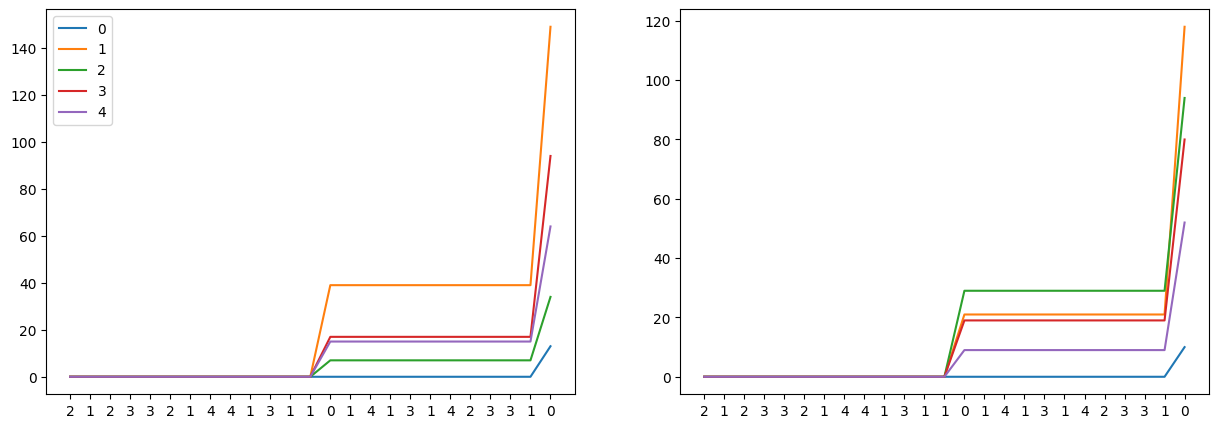

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in range(5):
    ax[0].plot(iss[0, exid, :, 0, i, 0], label=f"{i}")
    ax[1].plot(iss[0, exid, :, 1, i, 0], label=f"{i}")
ax[0].set_xticks([i for i in range(25)])
ax[0].set_xticklabels(x[exid].numpy())
ax[1].set_xticks([i for i in range(25)])
ax[1].set_xticklabels(x[exid].numpy())
ax[0].legend()

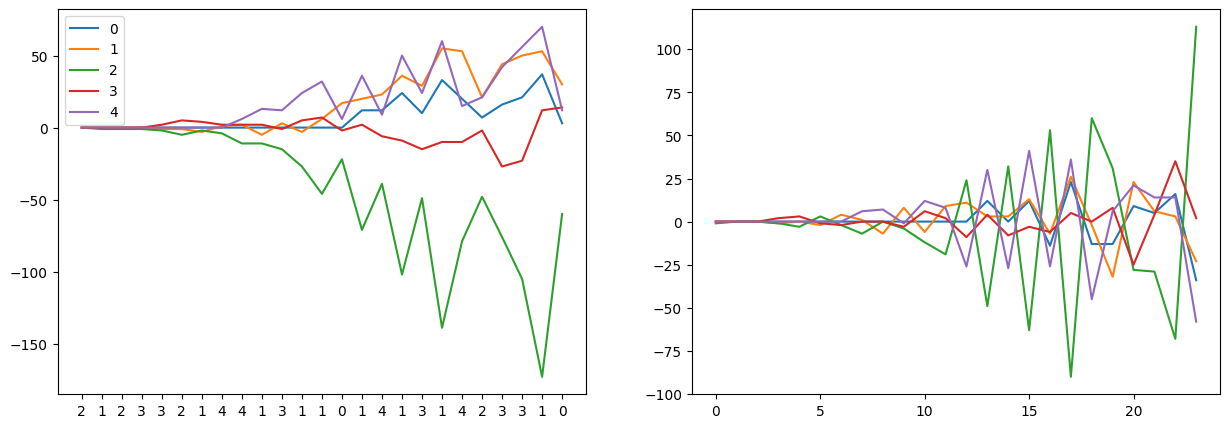

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in range(5):
    ax[0].plot(out[exid, :, i], label=f"{i}")
    ax[1].plot(out[exid, 1:, i]-out[exid, :-1, i], label=f"{i}")
ax[0].set_xticks([i for i in range(25)])
ax[0].set_xticklabels(x[exid].numpy())
ax[0].legend()

In [12]:
last_token_increase = np.zeros((x.shape[1], v.shape[-2], ))

for t in range(x.shape[1]):
    for t_2 in range(t+1):
        for t_1 in range(t_2):
            if t == x.shape[1] - 1:
                last_token_increase[t_2] = (
                    np.exp(-alpha*(1/(1+np.exp(-100)))*(t_2-t_1-1)/x.shape[1])
                    * np.cos(q[exid, t, 0, 1, 0] - k[exid, t_2, 0, 1, 0])
                    * np.cos(q[exid, t, 0, 1, 1] - k[exid, t_2, 0, 1, 1])
                    * np.cos(q[exid, t, 0, 1, 2] - k[exid, t_2, 0, 1, 2])
                    * v[exid, t_1, 0, 0, :, 0]
                )


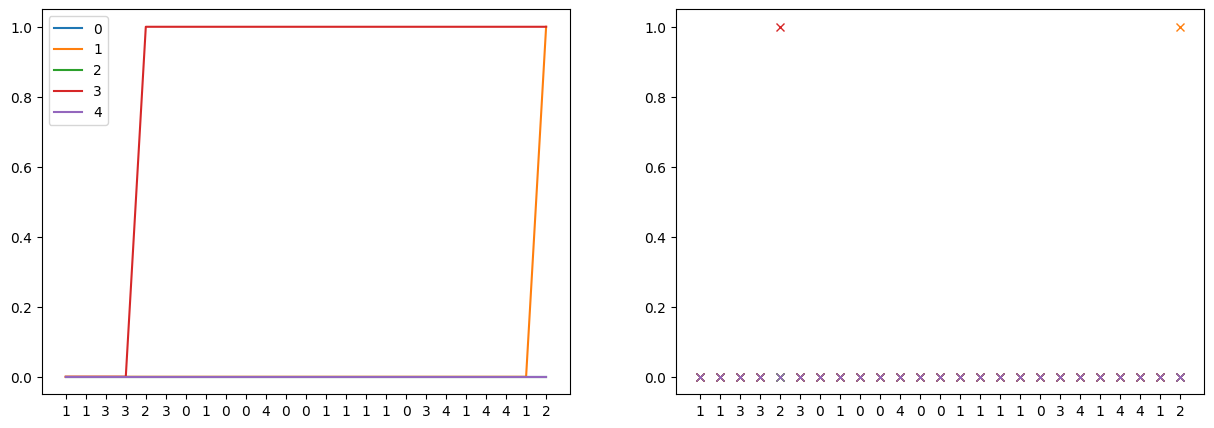

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
last_token_iss = np.cumsum(last_token_increase, axis=0)
for i in range(5):
    ax[0].plot(last_token_iss[:, i], "-", label=f"{i}")
    ax[1].plot(last_token_increase[:, i], "x", label=f"{i}")
ax[0].set_xticks([i for i in range(25)])
ax[1].set_xticks([i for i in range(25)])
ax[0].set_xticklabels(x[exid].numpy())
ax[1].set_xticklabels(x[exid].numpy())
ax[0].legend(loc="best")
plt.show()
# ax.set_yscale("log")